<a href="https://colab.research.google.com/github/jhportfolio1/MsAiSchool11-Language/blob/main/NLP02_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 허깅페이스 트랜스포머 모델 / 토크나이저 불러오기

>## 1) 텐서 설치

In [26]:
pip install -q datasets transformers torch tqdm tensorboard

>## 2) 토크나이커(tokenizer)
>- 입력된 텍스트를 모델이 처리할 수 있는 데이터로 변환
>- 텍스트를 토큰화하여 숫자로 변환
>- 토크나이저 종류
>>- 단어기반
>>- 문자기반
>>- 하위단어 기반 : 단어와 문자 사이의 처리방법
>- 모델 : 토크나이커로 변환된 토큰(숫자) 받아서 모델구조에 맞는 결과 도출

>## 3) 허깅페이스 트랜스포머
>- 다양한 구조, 모델 및 각 구조에 맞는 모델구조(언어분류등) 제공
>- 허깅페이스 허브에 업로드 된 것응로 사용가능

# 2. 실습
- 공개된 사전학습 모델 사용

>## 1) 전처리

In [27]:
#토치, 자동분류모델, 자동토큰화 가져오기 
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")


#데이터셋 가져오기
from datasets import load_dataset
dataset = load_dataset("nsmc")

#학습을 위해 숫자를 tensor로 변환
dataset = dataset.with_format("torch")


print(dataset['train'][0])

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

  0%|          | 0/2 [00:00<?, ?it/s]

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': tensor(0)}


In [28]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


#데이터셋 확인 (훈련/검증셋으로 나눠짐)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [29]:
#데이터프레임 정의 (pandas가 편리함)
df = pd.DataFrame(dataset['train'])

In [30]:
#데이터프레임
print('데이터프레임 크기 :',df.shape)
df.tail()

데이터프레임 크기 : (150000, 3)


,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,tensor(0)
149996,8549745,평점이 너무 낮아서...,tensor(1)
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,tensor(0)
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,tensor(1)
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,tensor(0)


In [31]:
#document 길이 컬럼 생성 (length)
df['length'] = df['document'].apply(lambda X: len(X))


# Postive/Negativ 라벨 생성 -> label_2
def pn(X):
    if X == 0:
        return 'Positive'
    else:
        return 'Negative'

df['label_2'] = df['label'].apply(pn)

df.tail()

,id,document,label,length,label_2
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,tensor(0),19,Positive
149996,8549745,평점이 너무 낮아서...,tensor(1),13,Negative
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,tensor(0),31,Positive
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,tensor(1),27,Negative
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,tensor(0),24,Positive


In [32]:
#데이터프레임개요
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  object
 1   document  150000 non-null  object
 2   label     150000 non-null  object
 3   length    150000 non-null  int64 
 4   label_2   150000 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.7+ MB


In [33]:
#positive/negative 갯수
df['label_2'].value_counts()

Positive    75173
Negative    74827
Name: label_2, dtype: int64

In [34]:
#document 길이(length) 통계
df['length'].describe()

count    150000.000000
mean         35.203353
std          29.532097
min           0.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64

In [35]:
#결측치 확인
df.isnull().sum()

id          0
document    0
label       0
length      0
label_2     0
dtype: int64

<Axes: >

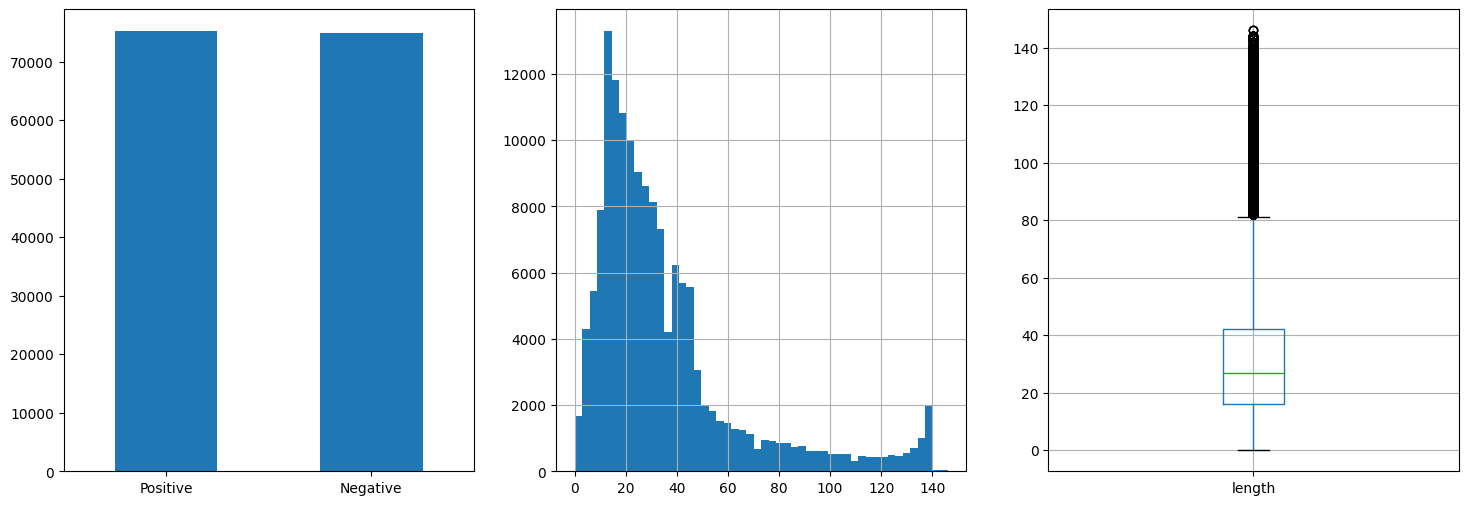

In [36]:
#분석내용시각화
plt.figure(figsize=(18,6))

#Positive/Negativ 비율
plt.subplot(1,3,1)
df['label_2'].value_counts().plot.bar()
plt.xticks(rotation=0)

#document 길이(lenght) 분포 (histogram)
plt.subplot(1,3,2)
df['length'].hist(bins=50)

#document 길이(lenght) 분포 (boxplot)
plt.subplot(1,3,3)
df.boxplot(column=['length'])

>## 2) 토크나이저 실습
>- 토크나이저와 모델은 훈련할때 쓴 것으로 동일하게 사용해야 함
>- CLS '아 더빙..' 뒤에 패딩토큰(0)이 있을 수 있음
>- attention_mask : 패딩토큰의 마스크로 0이면 훈련에 포함안됨

In [37]:
#토크나이저 사용예
inputs = tokenizer(dataset['train'][0]['document'])
print('tokenizer output key:', inputs.keys())
print('input text:',dataset['train'][0]['document'])
print('tokenizer encoding(input_ids):',inputs['input_ids'])
decode_inputs = tokenizer.decode(inputs['input_ids'])
print('tokenizer decoding:',decode_inputs)

tokenizer output key: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input text: 아 더빙.. 진짜 짜증나네요 목소리
tokenizer encoding(input_ids): [2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3]
tokenizer decoding: [CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]


In [38]:
#빠른 학습 및 검증 위한 데이터셋 수량 줄이기
train_dataset = dataset['train'].select(range(10000))
valid_dataset = dataset['test'].select(range(1000))

In [39]:
#데이터로더 정의
from torch.utils.data import DataLoader

train_batch_size = 32
valid_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)

In [40]:
#모델추론 예시

model.to('cuda')
model.eval()

test_index = 0
test_data = dataset['test'][test_index]
# test_text = test_data['document']

test_text = '킹 받는 영화'

inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
with torch.no_grad():
  logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(test_data)
print('prediction:',predicted_class_id)

RuntimeError: ignored

In [ ]:
#학습 전 검증(학습한 뒤 비교하기 위해)
from tqdm import tqdm

model.to('cuda')
model.eval()

before_ACCs=[]
for valid_batch in tqdm(valid_dataloader):

  inputs = tokenizer(valid_batch['document'], return_tensors='pt', padding=True).to(model.device)
  #print(inputs)
  with torch.no_grad():
    logits = model(**inputs).logits
  #print(logits)
  predicted_class_id = logits.argmax(dim=1).to('cpu')
  #print(predicted_class_id)
  #print(valid_batch['label'])
  acc=sum(predicted_class_id==valid_batch['label'])/len(valid_batch['label'])
  before_ACCs.append(acc)
print('')
print('valid ACC before training:',(sum(before_ACCs)/len(before_ACCs)*100).item(),'%')

In [41]:
#토큰수 확인
tokenizer.model_max_length

512

In [45]:
#모델학습 시각화 위한 텐서보드 정의
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/nsmc_experiment')

In [1]:
#모델학습

#model.to('cuda')
model.train()
learning_rate = 2e-4    #너무 낮으면 학습안되고, 너무 높으면 발산함 (2e-2 ~ 2e-4 사이에서 설정)
train_loss = 0.0
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loader = tqdm(train_dataloader)

#padding을 해서 길이를 맞춰줘야함
for i, train_batch in enumerate(train_loader):
  inputs = tokenizer(train_batch['document'], return_tensors='pt', padding=True).to(model.device)
  labels = train_batch['label'].to(model.device)

  outputs = model(**inputs, labels=labels)
  loss = outputs[0]
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  train_loss += loss
  if i == 0:
    writer.add_scalar('train loss', train_loss, i)
  elif i% 10 == 0:
    writer.add_scalar('train loss', train_loss/10, i)
    train_loss = 0.0
  
  train_loader.set_description("train loss %.04f | step %d" % (loss, i))

NameError: ignored

In [ ]:
#학습 시각화 : Train Loss
%load_ext tensorboard
%tensorboard --logdir {'/content/runs'}

In [ ]:
#학습후 검증
model.eval()

after_ACCs=[]
for valid_batch in tqdm(valid_dataloader):
  inputs = tokenizer(valid_batch['document'], return_tensors='pt', padding=True).to(model.device)
  with torch.no_grad():
    logits = model(**inputs).logits
  predicted_class_id = logits.argmax(dim=1).to('cpu')
  acc=sum(predicted_class_id==valid_batch['label'])/len(valid_batch['label'])
  after_ACCs.append(acc)
print('')
print('valid ACC after training:',(sum(after_ACCs)/len(after_ACCs)*100).item(),'%')

In [ ]:
#모델테스트 
test_text = '재밌더라'

model.eval()
print(f'input text:{test_text}')
inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
with torch.no_grad():
  logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
if predicted_class_id == 0:
  print('분석 결과: 부정')
else:
  print('분석 결과: 긍정')

>## 3) 모델 저장

In [ ]:
#학습 모델 저장
torch.save(model.state_dict(), './model1')

In [ ]:
#새 모델 불러오기
import torch 
from transformers import AutoModelForSequenceClassification, AutoTokenizer

new_model = AutoModelForSequenceClassification_pretrained('klue/bert-base')